In [1]:
from utils import *
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/features_30_sec.csv')

label_index = dict()
index_label = dict()
for i, x in enumerate(data.label.unique()):
    label_index[x] = i 
    index_label[i] = x
    
# update labels in df to index
data.label = [label_index[l] for l in data.label]


In [3]:
# Identify Features and Target Label
y = data['label']
X = data.drop(columns = ['label','filename','length'])


In [4]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)


X_dev shape: (800, 57)
X_test shape: (200, 57)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
model_xgb = XGBClassifier()
model_xgb.fit(X_dev, y_dev)
predsDevxgb = model_xgb.predict(X_dev)
predsTestxgb = model_xgb.predict(X_test)

In [6]:
testxgb_score =  accuracy_score(y_test, predsTestxgb)
devxgb_score = accuracy_score(y_dev, predsDevxgb)

In [7]:
print("Classification Score for XGB Classifier on Dev dataset:\n")
print("Dev Score : ", devxgb_score)
print(classification_report(y_dev, predsDevxgb))
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", testxgb_score)
print(classification_report(y_test, predsTestxgb))

Classification Score for XGB Classifier on Dev dataset:

Dev Score :  0.99875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        78
           4       1.00      1.00      1.00        81
           5       1.00      1.00      1.00        71
           6       0.99      1.00      0.99        81
           7       1.00      1.00      1.00        84
           8       1.00      1.00      1.00        78
           9       1.00      0.99      0.99        77

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.765
              precision    re

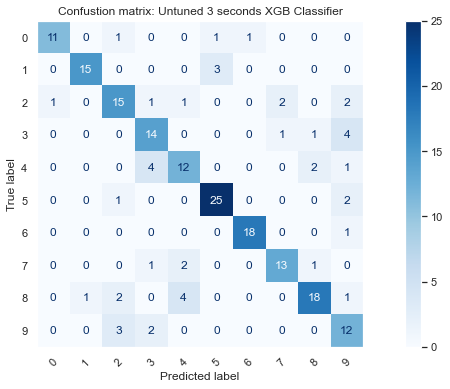

Accuracy : 0.77
Macro F-1 Score : 0.77


In [8]:
# Evaluate Model on Test set
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb, y_test, class_labels,
                                    'Confustion matrix: Untuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
parameters = {"n_estimators": [100],
            "learning_rate": [0.1],
            "max_depth": random.sample(range(3, 8), 2),
            'eval_metric':['logloss'],
            "use_label_encoder": [False]}
print(parameters)

{'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [7, 4], 'eval_metric': ['logloss'], 'use_label_encoder': [False]}


In [10]:
tune_xgb = GridSearchCV(estimator = model_xgb, param_grid = parameters, cv = 5)
tune_xgb.fit(X_dev, y_dev)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_ca..., max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                             

In [11]:
print("Best Score :", tune_xgb.best_score_)
print("Best Parameters :",tune_xgb.best_params_)

Best Score : 0.69125
Best Parameters : {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'use_label_encoder': False}


In [12]:
predsDevxgb_tuned = tune_xgb.predict(X_dev)
predsTestxgb_tuned = tune_xgb.predict(X_test)

print("Score on Dev data for xgb using GridSearchCV:", accuracy_score(y_dev, predsDevxgb_tuned))
print("Score on Test data for xgb using GridSearchCV:",accuracy_score(y_test, predsTestxgb_tuned))

Score on Dev data for xgb using GridSearchCV: 0.99875
Score on Test data for xgb using GridSearchCV: 0.73


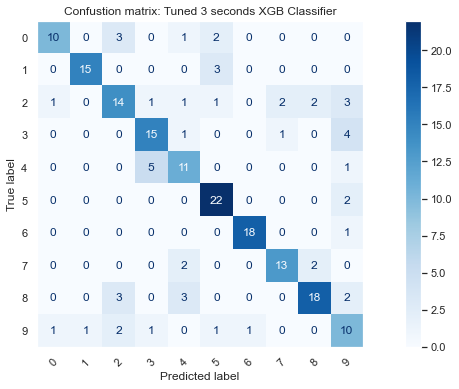

Accuracy : 0.73
Macro F-1 Score : 0.73


In [13]:
# Evaluate Model on Test set
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [14]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27766419 0.24831461 0.10817539 0.0735775  0.05921353 0.04313114
 0.03041835 0.02485929 0.02357102 0.0185913  0.01458576 0.01445453
 0.01236632 0.01085372 0.01042908 0.00964279 0.0091621  0.00839638
 0.00793391 0.007288   0.00723334 0.00675773 0.00606132 0.00560837
 0.00551568 0.00512515 0.005048   0.00465207 0.00453766 0.00424365]
Sum of Explained Variance: 0.9554594210812375


In [15]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209188,-0.328526,0.078992,-0.157340,...,0.039110,-0.014204,0.078314,0.042622,-0.020060,0.030908,0.072137,0.067118,-0.000046,0
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098223,-0.077308,0.046258,-0.040620,0.094613,...,-0.046610,-0.070303,-0.015955,0.048888,0.037215,0.008372,0.047849,0.013827,-0.019551,9
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150014,-0.066612,-0.197733,0.041882,0.013275,...,0.035752,0.009758,-0.059676,-0.157652,-0.008456,0.114495,0.030230,0.002393,-0.030806,8
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091608,0.131252,-0.044362,0.123941,...,0.003504,-0.002218,-0.015355,0.033183,-0.037312,0.013099,0.002479,0.022445,-0.026125,9
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025043,-0.233487,0.295031,0.131574,...,-0.082870,0.057519,-0.017711,-0.016841,0.001248,-0.046853,-0.035208,-0.021621,0.017791,8


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [16]:
model_pca = XGBClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxgb = model_pca.predict(pca_data)
pcaTestxgb = model_pca.predict(pca_data_test)

In [17]:
pcatestxgb_score =  accuracy_score(y_test, pcaTestxgb)
pcaxgb_score = accuracy_score(y_dev, pcaTrainxgb)

In [18]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxgb_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxgb_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.685


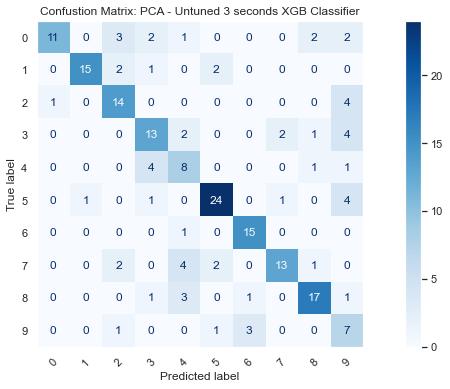

Accuracy : 0.69
Macro F-1 Score : 0.68


In [19]:
# Evaluate Model
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxgb, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [20]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209188,-0.328526,0.078992,-0.157340,...,0.041359,0.039110,-0.014204,0.078314,0.042622,-0.020060,0.030908,0.072137,0.067118,-0.000046
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098223,-0.077308,0.046258,-0.040620,0.094613,...,-0.041699,-0.046610,-0.070303,-0.015955,0.048888,0.037215,0.008372,0.047849,0.013827,-0.019551
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150014,-0.066612,-0.197733,0.041882,0.013275,...,0.088468,0.035752,0.009758,-0.059676,-0.157652,-0.008456,0.114495,0.030230,0.002393,-0.030806
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091608,0.131252,-0.044362,0.123941,...,-0.015402,0.003504,-0.002218,-0.015355,0.033183,-0.037312,0.013099,0.002479,0.022445,-0.026125
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025043,-0.233487,0.295031,0.131574,...,0.016698,-0.082870,0.057519,-0.017711,-0.016841,0.001248,-0.046853,-0.035208,-0.021621,0.017791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121275,0.170829,0.181529,-0.003558,...,0.293711,-0.012175,0.058480,0.048224,0.082594,-0.068041,0.015459,-0.020043,-0.000526,0.006661
796,0.258810,-0.934083,0.031836,0.495334,0.077337,-0.114135,0.171020,-0.128284,0.103762,0.171785,...,0.028815,-0.008404,-0.041049,0.057555,0.156682,0.046040,-0.126535,-0.038469,0.096648,0.001347
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291343,-0.171438,-0.020321,0.029576,-0.338980,...,-0.005502,-0.007773,0.011783,-0.003242,0.058010,0.003269,-0.060208,-0.102948,-0.045354,0.005836
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140385,-0.063130,-0.085623,-0.096352,0.127783,...,0.079952,-0.048846,0.017142,-0.003632,-0.024094,0.124307,-0.099110,-0.056262,0.028056,-0.100260


In [21]:
model_pca_tuned = tune_xgb
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxgb_tuned = model_pca_tuned.predict(pca_data)
pcaTestxgb_tuned = model_pca_tuned.predict(pca_data_test)

In [22]:
pcatestxgb_score =  accuracy_score(y_test, pcaTestxgb)
pcaxgb_score = accuracy_score(y_dev, pcaTrainxgb)

In [23]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxgb_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxgb_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.685


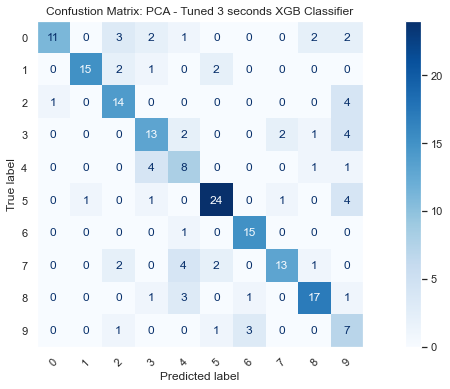

Accuracy : 0.69
Macro F-1 Score : 0.68


In [24]:
# Evaluate Model
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxgb, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 3 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)